In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
from models.sub_tcn import Sub_TCN
from models.gru import GRU

# Cosine Bases

In [2]:
cos_basis_no = 30
scale = 7.5
shift = 1
T_no = 500
        
kern_basis = torch.zeros(cos_basis_no, T_no)
for i in range(cos_basis_no):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = scale  * torch.log(x_in + shift + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis

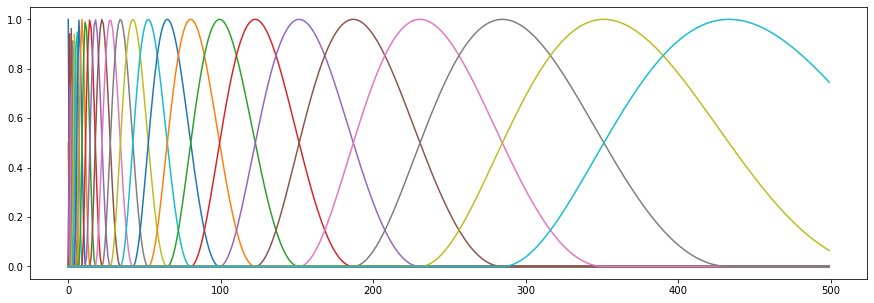

In [3]:
plt.figure(figsize = (15,5))
for i in range(cos_basis_no):
    plt.plot(kern_basis[i].cpu().detach().numpy())

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust8-30"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

"""
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
"""

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust8-30/data/handsub14_C_syn_e.npy")
C_syn_i = np.load("/media/hdd01/sklee/CA1_clust8-30/data/handsub14_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

#C_syn_e = C_syn_e[:,e_idx]
#C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 20
sub_no = 14
E_no = 2000
I_no = 200
#E_no = e_idx.shape[0]
#I_no = i_idx.shape[0]
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
#model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.035**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.035)

# GRU (1 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025/(1**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

21815


In [6]:
score_list = []

for i in tnrange(iter_no):
#for i in tnrange(10000):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _ = model(batch_E_neural, batch_I_neural)
    #V_pred, _, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    s = time.time()
    
    loss = torch.mean((V_pred- batch_V[:,:] )**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        #test_V_pred, test_sub_out, _ = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[:], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-6-4b6a7b36a77b>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.017488 0.082575
49 0.021035 0.039264
99 0.049013 0.037321
149 0.104576 0.035131
199 0.165122 0.032825
249 0.17931 0.032278
299 0.203775 0.031326
349 0.216768 0.03079
399 0.235663 0.029974
449 0.243246 0.02971
499 0.251878 0.029372
549 0.281902 0.028154
599 0.309046 0.027089
649 0.31951 0.026697
699 0.306036 0.027261
749 0.341132 0.025918
799 0.366403 0.024869
849 0.344229 0.02571
899 0.382394 0.024215
949 0.356426 0.025231
999 0.402119 0.023773
1049 0.40142 0.023488
1099 0.428172 0.022418
1149 0.39324 0.023788
1199 0.43884 0.02206
1249 0.418954 0.022779
1299 0.4448 0.021837
1349 0.437904 0.022039
1399 0.438336 0.022028
1449 0.45392 0.02142
1499 0.437293 0.022091
1549 0.455462 0.021385
1599 0.438405 0.022369
1649 0.450651 0.021587
1699 0.440804 0.021944
1749 0.468977 0.020963
1799 0.428524 0.022413
1849 0.454862 0.021373
1899 0.437893 0.022423


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2499 0.450673 0.021677
2549 0.466825 0.021028
2599 0.464332 0.021022
2649 0.47893 0.020444
2699 0.494669 0.019847
2749 0.475457 0.020565
2799 0.482722 0.020405
2849 0.471618 0.020873
2899 0.469054 0.02088
2949 0.456471 0.021568
2999 0.48853 0.02009
3049 0.446294 0.021745
3099 0.485595 0.020197
3149 0.486559 0.020246
3199 0.496662 0.019744
3249 0.499232 0.019735
3349 0.495251 0.019814
3399 0.503742 0.019833
3449 0.504014 0.01948
3499 0.488324 0.02006
3549 0.507315 0.019558
3599 0.508738 0.01926
3649 0.493945 0.019862
3699 0.484439 0.020463
3749 0.503272 0.019607
3799 0.492038 0.020001
3849 0.479958 0.020398
3899 0.499361 0.019801
3949 0.506477 0.019354
3999 0.479356 0.020452
4049 0.490126 0.020037
4099 0.504627 0.019442
4149 0.499785 0.019646
4199 0.488189 0.02018
4249 0.490487 0.01999
4299 0.511005 0.019187
4349 0.50368 0.019902
4399 0.485177 0.020187
4449 0.502689 0.019515
4499 0.493566 0.019927
4549 0.440909 0.021942
4599 0.515149 0.019145
4649 0.497486 0.01989
4699 0.506063 0.019435

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5149 0.505792 0.019407
5199 0.501781 0.019585
5249 0.502223 0.019572
5299 0.501737 0.019564
5349 0.506629 0.019355
5399 0.504177 0.01946
5449 0.482017 0.02032
5499 0.485371 0.02018
5549 0.481248 0.020433
5599 0.449721 0.022093
5649 0.500694 0.01958
5699 0.514122 0.019054
5749 0.494726 0.019868
5799 0.505384 0.019467
5849 0.467703 0.020874
5899 0.515298 0.019002
5949 0.497222 0.019758
5999 0.477359 0.020499
6049 0.509148 0.01941
6099 0.509461 0.01927
6149 0.52484 0.018629
6199 0.51169 0.019145
6249 0.517745 0.018942
6299 0.499681 0.019622
6349 0.504423 0.019606
6399 0.501313 0.019602
6449 0.512905 0.019106
6499 0.471511 0.020926
6549 0.510032 0.019224
6599 0.50755 0.019313
6649 0.488642 0.02025
6699 0.498743 0.019839


KeyboardInterrupt: 

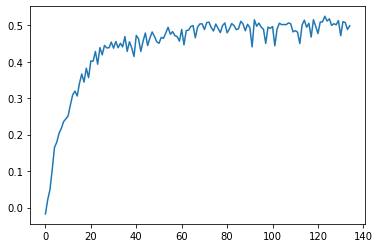

In [7]:
plt.plot(np.asarray(score_list))

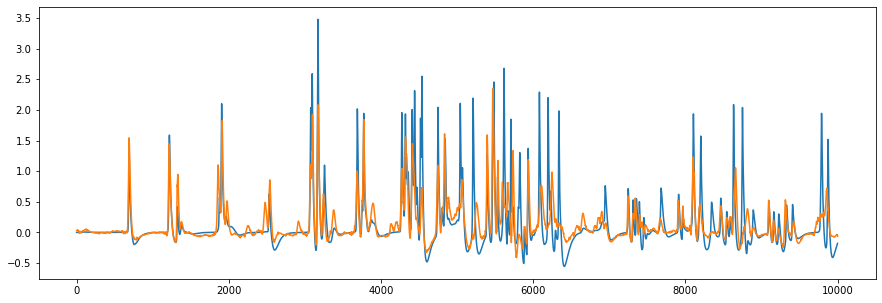

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:27000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:27000])

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust8-30/hand/gru_s14_h20.pt")